# 🚀 LangGraph QuickStart - 입문자를 위한 실전 튜토리얼

## 🎯 목표와 대상

이 노트북은 **LangGraph**를 처음 접하는 분을 위한 **실전 중심 튜토리얼** 입니다. 

### 📋 이 튜토리얼에서 만들 기능

- **🧠 기억력**: 이전 대화를 유지하는 상태 관리
- **🔍 검색 연동**: 외부 검색 도구로 최신 정보 확보  
- **🙋 인간 개입**: 승인 기반 Human-in-the-Loop
- **⏪ 상태 이력**: 체크포인트 기반 롤백 및 재실행

### 🏗️ 진행 로드맵

- **단계 1: 기본 챗봇 구축** — StateGraph, 메시지 흐름
- **단계 2: 도구 통합** — Tool 바인딩, 조건부 라우팅
- **단계 3: 메모리 추가** — 체크포인트, Thread ID
- **단계 4: Human-in-the-Loop** — interrupt, 승인 흐름
- **단계 5: 상태 커스터마이징** — 커스텀 State, Tool 업데이트
- **단계 6: 상태 이력 관리** — 이력 탐색, 롤백, 재실행

### 🛠️ 핵심 컴포넌트

- **🏗️ StateGraph**: 대화 프로세스 정의
- **🔨 Node**: 작업을 수행하는 함수 단위
- **🛤️ Edge**: 노드 간 실행 경로
- **📝 State**: 메시지와 컨텍스트 저장소
- **💾 Checkpointing**: 실행 시점 저장 및 복원

### ✅ 학습 성과

- **나만의 AI 비서**를 처음부터 끝까지 구현  
- **LangGraph 핵심 개념**의 실전 이해  
- **실무 적용 가능한 구조**와 패턴 확보  
- **확장 가능한 아키텍처** 설계 감각 습득

### 🔧 준비물

- **Python 3.11 이상**  
- **OpenAI API 키**  
- **Tavily Search API 키**  
- **LangSmith API 키** (선택)

### 📌 진행 방식

설명은 간결하게, 예시는 즉시 실행 가능한 코드로 제공합니다. 과장된 표현은 지양하고, 필요한 곳에만 이모지를 사용해 가독성을 높였습니다.  

**함께 구축해봅시다.** 🚀

## 🛠️ 환경 설정 - 최소 요구사항 정리

실행에 필요한 설정을 간단히 정리합니다. 과한 비유는 생략하고 필요한 항목만 빠르게 맞춥니다. 👇

### 🔧 준비 항목

1. **🔑 API 키 설정** — OpenAI, Tavily, (선택) LangSmith
2. **📊 추적 설정** — LangSmith로 실행 추적 (선택)

### 💡 이유

- **🔒 보안**: 키를 환경변수로 안전하게 관리
- **📈 모니터링**: 실행 경로와 비용 추적
- **🐛 디버깅**: 오류 발생 지점 신속 파악

바로 이어서 설정을 진행합니다. 🚀

In [1]:
# API KEY를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API KEY 정보로드
load_dotenv(override=True)

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("LangGraph-Tutorial")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-Tutorial


---

# Part 1: 기본 챗봇 구축 🤖

## 🎯 목적

가장 단순한 형태의 **메시지 기반 챗봇**을 구성합니다. 불필요한 수사는 줄이고, 구조와 흐름을 명확히 보여드립니다.

### 구성 요소

- **🏗️ StateGraph**: 전체 흐름 정의
- **📝 State**: 메시지 저장 구조
- **🔨 Node**: 처리 함수 (LLM 호출)
- **🛤️ Edge**: 실행 경로 연결
- **⚙️ Compile/Invoke**: 실행 준비 및 호출

### 왜 이렇게 구성하나요?

- **확장성**: 기능 추가가 용이
- **가독성**: 처리 단계를 분리해 이해 용이  
- **운영성**: 장애 구간을 빠르게 식별 가능

이제 바로 구현으로 들어갑니다. 🚀

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# State 정의: 챗봇의 상태를 나타내는 타입
class State(TypedDict):
    """챗봇의 상태를 정의하는 타입

    messages: 대화 메시지 리스트
    - add_messages 함수를 통해 새 메시지가 추가됨 (덮어쓰기가 아닌 추가)
    """

    messages: Annotated[list, add_messages]


# StateGraph 생성
graph_builder = StateGraph(State)

print("✅ StateGraph 생성 완료!")
print("📌 State는 messages 키를 가지며, add_messages 리듀서를 사용합니다.")

✅ StateGraph 생성 완료!
📌 State는 messages 키를 가지며, add_messages 리듀서를 사용합니다.


### 🧠 LLM 선택 및 설정

실습에서는 **GPT-4.1**을 사용합니다. 목적은 안정적인 답변이므로 `temperature=0` 으로 설정합니다.

- **모델**: gpt-4.1  
- **전략**: 일관성 우선 (창의성 최소화)  
- **이유**: 튜토리얼 재현성과 검증 용이성 확보

필요 시, 조직 환경의 모델로 교체해도 됩니다.

In [4]:
# LLM 선택
from langchain_openai import ChatOpenAI, AzureChatOpenAI

# OpenAI 모델 사용
llm = ChatOpenAI(model="gpt-4.1", temperature=0)

### 🔨 챗봇 노드 추가

대화 메시지를 입력받아 LLM에 전달하고, 응답 메시지를 상태에 추가합니다.

- **입력**: `State["messages"]`  
- **처리**: LLM 호출 후 응답 생성  
- **출력**: 새 메시지 1개 추가

필요한 최소 설명만으로 진행합니다.

In [5]:
def chatbot(state: State):
    """챗봇 노드 함수

    현재 상태의 메시지를 받아 LLM에 전달하고,
    응답을 새 메시지로 추가하여 반환합니다.
    """
    # LLM을 호출하여 응답 생성
    response = llm.invoke(state["messages"])

    # 응답을 메시지 리스트에 추가하여 반환
    return {"messages": [response]} # 공식 docs에서도 state 통채로 받는것보다 하나씩 반환하는게 더 일반적..



# 그래프에 노드 추가
# 첫 번째 인자: 노드의 고유 이름
# 두 번째 인자: 노드가 사용될 때 호출될 함수
graph_builder.add_node("chatbot", chatbot)

### 🚪 진입점과 종료점 설정

실행 경로를 명확히 정의합니다.

- **START**: 입력 수신  
- **chatbot**: LLM 호출 및 응답 생성  
- **END**: 결과 반환

가장 단순한 실행 흐름을 먼저 완성합니다.

In [6]:
# 진입점: 그래프 실행이 시작되는 지점
graph_builder.add_edge(START, "chatbot")

# 종료점: 그래프 실행이 끝나는 지점
graph_builder.add_edge("chatbot", END)

print("✅ 진입점과 종료점 설정 완료!")
print("📌 실행 흐름: START → chatbot → END")

✅ 진입점과 종료점 설정 완료!
📌 실행 흐름: START → chatbot → END


### ⚡ 그래프 컴파일

구성한 그래프를 실행 가능한 형태로 컴파일합니다. 사전 검증을 통해 런타임 오류를 줄이고, 실행 준비를 마칩니다.

- **검증**: 연결 관계, 의존성 확인  
- **최적화**: 실행 준비 및 성능 기본 튜닝  
- **안정성**: 사전 검사로 오류 가능성 축소

In [7]:
# 그래프 컴파일
graph = graph_builder.compile()

print("✅ 그래프 컴파일 완료!")

✅ 그래프 컴파일 완료!


### 👀 그래프 시각화

구성한 그래프를 시각화해 구조를 빠르게 확인합니다.

- **노드**: 처리 단위  
- **엣지**: 실행 경로  
- **START/END**: 시작/종료 포인트

시각화는 구조 검증과 이해를 빠르게 돕습니다.

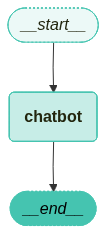

In [8]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

### 🎉 챗봇 실행

간단한 질문으로 그래프를 실행해 정상 동작을 확인합니다.

- **질문 예시**: "LangGraph에 대해 알려주세요"  
- **흐름**: START → chatbot → END  
- **주의**: `recursion_limit`, `thread_id` 등 설정값은 재현성에 영향을 줍니다.

바로 실행해보겠습니다. 🎧

In [9]:
from langchain_teddynote.messages import stream_graph
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import HumanMessage

# 질문 입력
user_input = "안녕하세요! LangGraph에 대해 알려주세요."

# Config 설정(recursion_limit: 재귀 깊이 제한, thread_id: 스레드 아이디)
config = RunnableConfig(recursion_limit=20, thread_id="abc123") # node 1개당 1 / 3개 노드 방문했다? 3 roop 기준이 아님


In [10]:
inputs = {
    "messages": [HumanMessage(content="안녕하세요! LangGraph에 대해 알려주세요.")]
}

# 그래프 스트리밍
stream_graph(graph, inputs=inputs, config=config)


🔄 Node: chatbot 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요! LangGraph에 대해 설명드리겠습니다.

**LangGraph란?**

LangGraph는 **LangChain** 팀에서 개발한, LLM(대형 언어 모델) 기반 애플리케이션을 위한 **멀티에이전트 워크플로우**를 쉽게 구축할 수 있도록 도와주는 오픈소스 프레임워크입니다. 쉽게 말해, 여러 LLM 에이전트(예: 챗봇, 도우미, 분석가 등)가 서로 협력하거나, 순차적으로 작업을 처리하는 복잡한 플로우를 **그래프(노드와 엣지)** 형태로 설계하고 실행할 수 있게 해줍니다.

---

### 주요 특징

1. **그래프 기반 워크플로우**
   - 각 노드는 LLM 에이전트, 함수, 도구 등 다양한 작업 단위를 나타냅니다.
   - 노드 간의 연결(엣지)을 통해 데이터 흐름과 조건 분기를 설계할 수 있습니다.

2. **멀티에이전트 시스템**
   - 여러 LLM 에이전트가 서로 대화하거나, 협업하는 시나리오를 쉽게 구현할 수 있습니다.
   - 예: 한 에이전트가 요약을 하고, 다른 에이전트가 번역을 하는 식의 파이프라인.

3. **상태 관리**
   - 각 노드(에이전트)는 상태(state)를 주고받으며, 복잡한 대화나 작업 흐름을 관리할 수 있습니다.

4. **LangChain과의 통합**
   - LangChain의 체인, 에이전트, 도구 등과 자연스럽게 연동됩니다.

---

### 사용 예시

```python
from langgraph.graph import StateGraph, END
from langchain.llms import OpenAI

# 1. 상태 정의
class MyState(TypedDict):
    input: str
    summary: str

# 2. 노드(작업) 정의
def summarize(state):
    summary = ... # LLM을 이용한 요약 작업
    re

---

# Part 2: 도구(Tools) 추가 🔧

## 🎯 목적
실시간 정보가 필요한 요청에 대응하기 위해 외부 검색 도구를 통합합니다.

### 왜 필요한가
- **지식 한계 보완**: 모델 학습 시점 이후의 정보 조회
- **팩트 체크**: 출처 기반 검증 강화
- **실무 친화성**: 최신 데이터 기반 응답

### 핵심 개념
- **Tool Binding**: LLM이 도구를 호출할 수 있도록 연결
- **Tool Node**: 외부 API 호출을 담당하는 노드
- **Conditional Edges**: 도구 사용 여부를 자동으로 분기

### 기대 효과
- **실시간성**, **정확성**, **확장성** 향상

In [11]:
# 공유
from langchain_core.tools import tool

@tool
def add(a: int, b: int):
    "add two numbers"
    return a + b

In [12]:
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition

# Tavily 검색 도구 설정
tool = TavilySearch(max_results=2)
tools = [tool, add]

# 도구 테스트
result = tool.invoke("LangGraph란 무엇인가요?")
print(f"검색 결과 수: {len(result['results'])}개")
print(f"첫 번째 결과 제목: {result['results'][0]['title']}")

검색 결과 수: 2개
첫 번째 결과 제목: langgraph 소개 및 기본개념 : 네이버 블로그


### 🏗️ 도구 사용 그래프 구성

기본 흐름에 도구 호출 경로를 추가합니다.

- 기존: 사용자 → chatbot → END
- 변경: 사용자 → chatbot ⇄ tools → chatbot → END

핵심 요소
- **Tool 바인딩**  
- **ToolNode 추가**  
- **조건부 분기 적용**

In [13]:
llm_with_tools = llm.bind_tools(tools)

In [14]:
ret1 = llm_with_tools.invoke("LangGraph 가 뭐야?")
ret2 = llm_with_tools.invoke("LangGraph 가 뭐야? 검색해서 알려줘")
ret3 = llm_with_tools.invoke("1+2는 뭐야?")

In [15]:
from langchain_teddynote.messages import display_message_tree

display_message_tree(ret1)

    content: "**LangGraph**는 LLM(대형 언어 모델, Large Language Model) 기반의 애플리케이션을 더 쉽게 만들고, 복잡한 대화 흐름이나 워크플로우를 설계할 수 있도록 도와주는 오픈소스 프레임워크입니다. 주로 Python과 TypeScript로 제공되며, LangChain 프로젝트의 일부로 개발되었습니다.

### 주요 특징
- **그래프 기반 워크플로우**: LangGraph는 "상태 머신" 또는 "그래프" 구조를 사용하여, 여러 단계로 이루어진 복잡한 대화나 작업 흐름을 시각적으로 설계할 수 있습니다.
- **노드와 엣지**: 각 단계(노드)는 LLM 호출, 함수 실행, 조건 분기 등 다양한 작업을 할 수 있고, 노드 간의 연결(엣지)을 통해 흐름을 제어합니다.
- **비동기/동기 지원**: 복잡한 멀티스텝 프로세스, 반복, 조건 분기, 에러 핸들링 등을 쉽게 구현할 수 있습니다.
- **LangChain과 통합**: LangChain의 체인, 에이전트, 툴 등과 쉽게 연동됩니다.

### 예시 사용처
- 챗봇에서 여러 단계로 질문을 받고, 조건에 따라 다른 답변을 주는 경우
- LLM을 활용한 데이터 파이프라인 자동화
- 복잡한 에이전트 워크플로우 설계

### 간단한 코드 예시 (Python)
```python
from langgraph.graph import StateGraph

# 그래프 생성
graph = StateGraph()

# 노드(단계) 추가
graph.add_node("start", start_function)
graph.add_node("process", process_function)
graph.add_node("end", end_function)

# 노드 연결
graph.add_edge("start", "process")
graph.add_edge("process", "end")

# 그래프 실행
result = graph.run(input_data)
```

### 참고 자료
- [Lang

In [16]:
display_message_tree(ret2)

    content: ""
    additional_kwargs:
        tool_calls:
            index [0]
                id: "call_V3mnOglia39A3QoRzTaKbAap"
                function: {"arguments": "{"query":"LangGraph란 무엇인가"}", "name": "tavily_search"}
                type: "function"
        refusal: None
    response_metadata:
        token_usage:
            completion_tokens: 20
            prompt_tokens: 1299
            total_tokens: 1319
            completion_tokens_details: {"accepted_prediction_tokens": 0, "audio_tokens": 0, "reasoning_tokens": 0, "rejected_prediction_tokens": 0}
            prompt_tokens_details: {"audio_tokens": 0, "cached_tokens": 1280}
        model_name: "gpt-4.1-2025-04-14"
        system_fingerprint: "fp_422e2d36a8"
        id: "chatcmpl-CRJZBrE8oTE54spX7EeEpvHi4cxKY"
        service_tier: "default"
        finish_reason: "tool_calls"
        logprobs: None
    type: "ai"
    name: None
    id: "run--d319147f-1c36-4a09-9cec-a7b292f7d063-0"
    example: False
    tool_calls:
 

In [17]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# State 정의 (동일)
class State(TypedDict):
    messages: Annotated[list, add_messages]


# 새로운 그래프 빌더 생성
builder = StateGraph(State)

# LLM에 도구 바인딩 - LLM이 도구를 사용할 수 있도록 설정
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    """도구를 사용할 수 있는 챗봇 노드"""
    # 도구가 바인딩된 LLM 호출
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}


# 노드 추가
builder.add_node("chatbot", chatbot)

# ToolNode 추가 - 도구를 실행하는 노드
tool_node = ToolNode(tools=tools)
builder.add_node("tools", tool_node)

### 🚦 조건부 라우팅(Conditional Edges)

요청에 따라 자동으로 경로를 선택합니다.

- **외부 검색 필요**: "tools" 로 이동  
- **내부 처리 가능**: 종료

핵심: `tools_condition` 이 마지막 AI 메시지의 `tool_calls` 존재 여부를 확인합니다.

이 구조로 불필요한 도구 호출을 줄이고 응답 속도를 확보합니다.

### 🔍 tools_condition 동작 요약

`tools_condition` 은 마지막 AI 메시지에 도구 호출이 있는지 확인해 분기합니다.

- `tool_calls` 있음 → "tools"  
- `tool_calls` 없음 → "__end__"

간단한 구현 예시는 아래와 같습니다.

```python
def tools_condition(state) -> Literal["tools", "__end__"]:
    # 마지막 메시지 추출
    ai_message = state[-1] if isinstance(state, list) else state["messages"][-1]
    # 분기 판단
    return "tools" if getattr(ai_message, "tool_calls", []) else "__end__"
```

In [18]:
# 조건부 엣지 추가
# tools_condition은 메시지에 tool_calls가 있으면 "tools"로,
# 없으면 END로 라우팅합니다
builder.add_conditional_edges(
    "chatbot",
    tools_condition,  # 사전 정의된 조건 함수 사용

    #만약 my_tools? 로 이름을 지었다면 여기다가 tools는 my_tools라고 선언 해줘야됨
)

# 도구 실행 후 다시 챗봇으로 돌아가기
builder.add_edge("tools", "chatbot")

# 시작점 설정
builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph_with_tools = builder.compile()

### 👀 업그레이드 그래프 시각화

변경된 구조를 시각화해 분기와 루프를 확인합니다.

- 새 노드: `tools`  
- 분기: `chatbot` → 판단 → `tools` 또는 종료  
- 루프: `tools` → `chatbot`

시각화를 통해 설정이 의도대로 적용되었는지 빠르게 검증합니다.

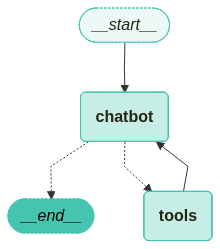

In [19]:
# 그래프 시각화
visualize_graph(graph_with_tools)

### 🚀 도구 사용 테스트

실시간 정보가 필요한 질문으로 동작을 확인합니다.

- **예시 질문**: "2025년 LangGraph 사용 사례 알려주세요."  
- **기대 흐름**: `chatbot` → `tools` → `chatbot` → END  
- **확인 포인트**: 검색 호출 여부, 결과 정리 품질, 응답 자연스러움

이제 실행해 결과를 확인합니다. 🧪

In [20]:
from langchain_teddynote.messages import stream_graph

stream_graph(
    graph_with_tools,
    inputs={
        "messages": [HumanMessage(content="2025년 LangGraph 사용 사례 알려주세요.")]
    },
    config=config,
)


🔄 Node: chatbot 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"query": "2025년 LangGraph 사용 사례", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://medium.com/@sumit.work.connect/langgraph-in-action-trends-use-cases-and-how-to-build-with-it-in-2025-981e8e50dedd", "title": "LangGraph in Action: Trends, Use Cases, and How to build with It in ...", "content": "Sitemap\n\nOpen in app\n\nSign in\n\nSign in\n\n# LangGraph in Action: Trends, Use Cases, and How to build with It in 2025\n\n## Think in Graphs: The Smart Way to Build with LLMs\n\nSunny Singh\n\n3 min readApr 19, 2025\n\nAs AI apps powered by LLMs evolve, so do the challenges: complex workflows, juggling agent memory, and making real time decisions. That’s where LangGraph steps in — a next gen framework from LangChain that turns traditional linear flows into smart, memory-driven graph-based systems. [...] LangGraph is n

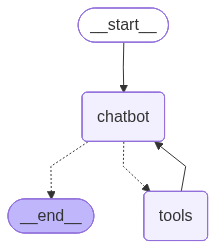

In [22]:
graph_with_tools

In [21]:
from langchain_teddynote.messages import stream_graph

stream_graph(
    graph_with_tools,
    inputs={
        "messages": [HumanMessage(content="1+2 가 뭐야?")]
    },
    config=config,
)


🔄 Node: chatbot 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
3
🔄 Node: chatbot 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
1 + 2는 3입니다.

---

# Part 3: 메모리 추가 💾

## 🎯 목적
세션 간에도 사용자 정보를 유지하는 **영구 상태 관리**를 추가합니다.

### Before
- 세션이 바뀌면 이전 정보 소실

### After
- 사용자별로 중요한 정보를 저장하고 재사용

### 핵심 개념
- **💾 Checkpointer**: 대화 상태 저장/복원
- **🏷️ Thread ID**: 세션 식별자
- **🗂️ Persistent State**: 누적 이력 기반 컨텍스트

### 기대 효과
- **연속 대화**, **개인화**, **컨텍스트 안정성**

In [38]:
from typing import List, Optional
from datetime import datetime
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import PydanticOutputParser
import os


# Pydantic 모델 정의
class MemoryItem(BaseModel):
    """개별 메모리 아이템"""

    key: str = Field(description="메모리 키 (예: user_name, preference, fact)")
    value: str = Field(description="메모리 값")
    category: str = Field(
        description="카테고리 (personal_info, preference, interest, relationship, fact, etc.)"
    )
    importance: int = Field(description="중요도 (1-5, 5가 가장 중요)", ge=1, le=5)
    confidence: float = Field(description="추출 신뢰도 (0.0-1.0)", ge=0.0, le=1.0)


class ExtractedMemories(BaseModel):
    """추출된 메모리 컬렉션"""

    memories: List[MemoryItem] = Field(description="추출된 메모리 아이템 리스트")
    summary: str = Field(description="대화 내용 요약")
    timestamp: str = Field(
        default_factory=lambda: datetime.now().isoformat(), description="추출 시간"
    )


# 기본 시스템 프롬프트
DEFAULT_SYSTEM_PROMPT = """You are an expert memory extraction assistant. Your task is to extract important information from user conversations and convert them into structured key-value pairs for long-term memory storage.

Extract ALL relevant information from the conversation, including:
- Personal information (name, age, location, occupation, etc.)
- Preferences and interests
- Relationships and social connections
- Important facts or events mentioned
- Opinions and beliefs
- Goals and aspirations
- Any other notable information

For each piece of information:
1. Create a concise, searchable key
2. Store the complete value
3. Categorize appropriately
4. Assess importance (1-5 scale)
5. Evaluate extraction confidence (0.0-1.0)"""


def create_memory_extractor(
    model: Optional[str] = "gpt-4.1",
    system_prompt: Optional[str] = None,
) -> any:
    """
    메모리 추출기를 생성합니다.

    Args:
        model: 사용할 언어 모델. None일 경우 기본 ChatOpenAI 모델 사용
        system_prompt: 시스템 프롬프트. None일 경우 기본 프롬프트 사용

    Returns:
        메모리 추출 체인
    """
    # Output Parser 생성
    memory_parser = PydanticOutputParser(pydantic_object=ExtractedMemories)

    # 시스템 프롬프트 설정
    if system_prompt is None:
        system_prompt = DEFAULT_SYSTEM_PROMPT

    # 전체 프롬프트 템플릿 구성
    template = f"""{system_prompt}

User Input: {{input}}

{{format_instructions}}

Remember to:
- Extract multiple memory items if the conversation contains various pieces of information
- Use clear, consistent key naming conventions
- Preserve context in values when necessary
- Be comprehensive but avoid redundancy
"""

    # 프롬프트 생성
    prompt = ChatPromptTemplate.from_template(
        template,
        partial_variables={
            "format_instructions": memory_parser.get_format_instructions()
        },
    )

    # 모델 설정
    model = AzureChatOpenAI(
        deployment_name="gpt-4.1-mini",  # 사용하는 모델명(deployment_name)
        api_version="2024-12-01-preview",
        azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
        api_key=os.environ["AZURE_OPENAI_API_KEY"],
    )

    # 메모리 추출 체인 생성
    memory_extractor = prompt | model | memory_parser

    return memory_extractor

In [39]:
from typing import Any
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.store.base import BaseStore
from langchain_openai import ChatOpenAI

from langchain_teddynote.memory import create_memory_extractor
import uuid

model = ChatOpenAI(model="gpt-4.1", temperature=0)
memory_extractor = create_memory_extractor(model="gpt-4.1")


def call_model(
    state: MessagesState,
    config: RunnableConfig,
    *,
    store: BaseStore,
) -> dict[str, Any]:
    """Call the LLM model and manage user memory.

    Args:
        state (MessagesState): The current state containing messages.
        config (RunnableConfig): The runnable configuration.
        store (BaseStore): The memory store.
    """
    # 마지막 메시지에서 user_id 추출
    user_id = config["configurable"]["user_id"]
    namespace = ("memories", user_id)

    print(namespace)

    # 유저의 메모리 검색
    memories = store.search(namespace, query=str(state["messages"][-1].content))
    info = "\n".join([f"{memory.key}: {memory.value}" for memory in memories])
    system_msg = f"You are a helpful assistant talking to the user. User info: {info}"

    # 사용자가 기억 요청 시 메모리 저장
    last_message = state["messages"][-1]
    if "remember" in last_message.content.lower():
        result = memory_extractor.invoke({"input": str(state["messages"][-1].content)})
        for memory in result.memories:
            print(memory)
            print("-" * 100)
            store.put(namespace, str(uuid.uuid4()), {memory.key: memory.value})

    # LLM 호출
    response = model.invoke(
        [{"role": "system", "content": system_msg}] + state["messages"]
    )
    return {"messages": response}

In [40]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore

# 그래프 빌드
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_edge(START, "call_model")

# 메모리 체크포인터 생성
# 실제 프로덕션에서는 PostgresSaver 사용 권장
memory_saver = InMemorySaver()
memory_store = InMemoryStore()

# 그래프 컴파일
graph_with_memory = builder.compile(
    checkpointer=memory_saver,
    store=memory_store,
)

In [41]:
from langchain_teddynote.messages import stream_graph


def run_graph(
    msg,
    thread_id="default",
    user_id="default",
):
    config = {
        "configurable": {
            "thread_id": thread_id + user_id,
            "user_id": user_id,
        }
    }
    print(f"\n[유저🙋] {msg}")
    stream_graph(
        graph_with_memory,
        inputs={"messages": [{"role": "user", "content": msg}]},
        config=config,
    )
    print()

In [42]:
# 메시지, thread_id, user_id 전달
run_graph("안녕? 내 이름은 테디야", "1", "someone")


[유저🙋] 안녕? 내 이름은 테디야
('memories', 'someone')

🔄 Node: call_model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕, 테디! 만나서 반가워. 오늘은 어떤 도움이 필요해? 😊


In [43]:
# 메시지, thread_id, user_id 전달
run_graph("내 이름이 뭐라고?", "1", "someone")


[유저🙋] 내 이름이 뭐라고?
('memories', 'someone')

🔄 Node: call_model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
네 이름은 테디라고 했지! 맞지? 😊


In [44]:
# 메시지, thread_id, user_id 전달
run_graph("내 이름이 뭐라고?", "2", "someone")


[유저🙋] 내 이름이 뭐라고?
('memories', 'someone')

🔄 Node: call_model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
죄송하지만, 아직 당신의 이름을 알지 못해요. 이름을 알려주시면 앞으로 그렇게 불러드릴게요!


### 🧠 장기 기억 저장: `remember` 키워드

메시지에 `remember` 가 포함되면 중요 정보를 장기 저장소에 기록합니다.

- **예시**: "내 이름은 테디야 remember"  
- **저장 대상**: 이름, 직업, 선호 등 사용자 프로필성 정보  
- **기본 원칙**: 일반 대화는 단기 컨텍스트로만 유지

In [45]:
# 메시지, thread_id, user_id 전달
run_graph("내 이름이 테디야 remember", "2", "someone")


[유저🙋] 내 이름이 테디야 remember
('memories', 'someone')

🔄 Node: call_model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{
  "memories": [
    {
      "key": "user_name",
      "value": "테디",
      "category": "personal_info",
      "importance": 5,
      "confidence": 1.0
    }
  ],
  "summary": "사용자는 자신의 이름이 '테디'라고 밝혔음.",
  "timestamp": "2024-06-14T00:00:00Z"
}key='user_name' value='테디' category='personal_info' importance=5 confidence=1.0
----------------------------------------------------------------------------------------------------
알겠어요, 테디! 앞으로 테디라고 부를게요. 궁금한 점이나 도움이 필요하면 언제든 말씀해 주세요. 😊


### 🌟 Thread 간 지속성

사용자 기반 장기 기억은 Thread 가 달라도 유지됩니다.

- **Short-term Memory**: Thread 컨텍스트(세션 단위)
- **Long-term Memory**: User ID 기반 프로필(세션 간 유지)

실무에서도 사용자 정보는 클라이언트가 달라도 유지되는 것이 일반적입니다.

In [46]:
# 메시지, thread_id, user_id 전달
run_graph("내 이름이 뭐라고 했더라?", "3", "someone")


[유저🙋] 내 이름이 뭐라고 했더라?
('memories', 'someone')

🔄 Node: call_model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
당신의 이름은 "테디"라고 하셨어요! 😊


In [47]:
# 메시지, thread_id, user_id 전달
run_graph(
    "내 직업은 AI Engineer 야. 내 취미는 Netflix 보기 야. remember", "4", "someone"
)


[유저🙋] 내 직업은 AI Engineer 야. 내 취미는 Netflix 보기 야. remember
('memories', 'someone')

🔄 Node: call_model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{
  "memories": [
    {
      "key": "occupation",
      "value": "AI Engineer",
      "category": "personal_info",
      "importance": 5,
      "confidence": 1.0
    },
    {
      "key": "hobby",
      "value": "Netflix 보기",
      "category": "preference",
      "importance": 4,
      "confidence": 1.0
    }
  ],
  "summary": "사용자는 자신의 직업이 AI Engineer이며, 취미는 Netflix 보기라고 밝혔다.",
  "timestamp": "2024-06-13T00:00:00Z"
}key='occupation' value='AI Engineer' category='personal_info' importance=5 confidence=1.0
----------------------------------------------------------------------------------------------------
key='hobby' value='Netflix 보기' category='preference' importance=4 confidence=1.0
----------------------------------------------------------------------------------------------------
알겠어, 테디!  
너의 직업은 AI Engineer이고, 취미는 Netflix 보기인 걸 

In [48]:
# 다른 스레드에서 실행
run_graph("내 이름, 직업, 취미 알려줘", "100", "someone")


[유저🙋] 내 이름, 직업, 취미 알려줘
('memories', 'someone')

🔄 Node: call_model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
네, 테디님!  
아래는 요청하신 정보입니다.

- 이름: 테디
- 직업: AI Engineer
- 취미: Netflix 보기

다른 궁금한 점 있으시면 언제든 말씀해 주세요! 😊


In [49]:
# 다른 user_id 로 실행한 경우
run_graph("내 이름, 직업, 취미 알려줘", "100", "other")


[유저🙋] 내 이름, 직업, 취미 알려줘
('memories', 'other')

🔄 Node: call_model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
제가 아직 당신의 이름, 직업, 취미에 대한 정보를 받지 못했어요. 알려주시면 기억해서 대화에 반영할 수 있습니다! 알려주실래요? 😊


### 🔍 State 확인

현재 저장된 상태를 조회해 메시지 이력과 체크포인트 정보를 확인합니다.

- **메시지 수**  
- **체크포인트 ID**  
- **최근 메시지 내용**

상태 조회는 디버깅과 검증에 유용합니다.

In [50]:
# 임의의 Config 설정
config = {
    "configurable": {
        "thread_id": "100" + "someone",
        "user_id": "someone",
    }
}

# 현재 상태 가져오기
snapshot = graph_with_memory.get_state(config)

print("📊 현재 상태 정보:")
print(f"- 메시지 수: {len(snapshot.values['messages'])}개")
print(f"- 체크포인트 ID: {snapshot.config['configurable']['checkpoint_id']}")

# 최근 메시지 몇 개 표시
print("\n[최근 메시지]")
for msg in snapshot.values["messages"]:
    role = msg.type if hasattr(msg, "type") else "unknown"
    content = msg.content if hasattr(msg, "content") else str(msg)
    print(f"  [{role}]: {content}")

📊 현재 상태 정보:
- 메시지 수: 2개
- 체크포인트 ID: 1f0aa584-c197-68fa-8001-8a76cfd42de1

[최근 메시지]
  [human]: 내 이름, 직업, 취미 알려줘
  [ai]: 네, 테디님!  
아래는 요청하신 정보입니다.

- 이름: 테디
- 직업: AI Engineer
- 취미: Netflix 보기

다른 궁금한 점 있으시면 언제든 말씀해 주세요! 😊


In [51]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='내 이름, 직업, 취미 알려줘', additional_kwargs={}, response_metadata={}, id='552f6592-8259-4823-b502-5a6192c80dfa'), AIMessage(content='네, 테디님!  \n아래는 요청하신 정보입니다.\n\n- 이름: 테디\n- 직업: AI Engineer\n- 취미: Netflix 보기\n\n다른 궁금한 점 있으시면 언제든 말씀해 주세요! 😊', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_e24a1fec47', 'service_tier': 'default'}, id='run--c2db083d-84b1-4cae-b331-71a635a0de0e', usage_metadata={'input_tokens': 134, 'output_tokens': 51, 'total_tokens': 185, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}, next=(), config={'configurable': {'thread_id': '100someone', 'checkpoint_ns': '', 'checkpoint_id': '1f0aa584-c197-68fa-8001-8a76cfd42de1'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}, 'user_id': 'someone'}, created_at='2025-10-16T06:21:05.906705+00:00', parent_config={'configurable': {'t

---

# Part 4: Human-in-the-Loop 🙋

## 🎯 목적
고위험/중요 작업에 대해 AI가 스스로 멈추고 인간 승인을 요청하는 승인 기반 흐름을 도입합니다.

### 언제 승인이 필요한가
- **💰 금융 처리**: 결제/이체/투자
- **🏥 의료 조언**: 처방/치료 권고
- **📧 대외 커뮤니케이션**: 공지/발송
- **🔐 보안 변경**: 권한/설정

### 핵심 개념
- **⏸️ interrupt**: 실행 일시정지 및 승인 대기
- **📋 Command**: 승인/거부 후 재개 명령
- **👔 Human Approval**: 승인 워크플로우(검토 → 결정 → 재개)

### 아키텍처
```
사용자 요청 → AI 분석 → ⏸️ 승인 필요 판단
                  ↓
               인간 검토 → ✅ 승인 / ❌ 거부
                  ↓
                 ▶️ 재개 및 안전 실행
```

### 기대 효과
- **안전성 향상**, **신뢰성 확보**, **협업 강화**, **정책 준수**

In [52]:
from langchain_core.tools import tool
from langgraph.types import Command, interrupt


@tool
def human_assistance(query: str) -> str:
    """Request assistance from an expert(human)."""
    # interrupt를 호출하여 실행 일시 중지
    # 사람의 응답을 기다림
    human_response = interrupt({"query": query})

    # 사람의 응답 반환
    return human_response["data"]

### 🏗️ HITL 그래프 구성

`human_assistance` 도구를 통해 승인 지점을 구현합니다.

- **역할**: 필요 시 interrupt 로 중단 후 인간 답변 대기  
- **흐름**: chatbot → tools(`human_assistance`) → chatbot → END  
- **주의**: interrupt 와 병렬 도구 호출은 함께 사용하지 않습니다(재개 시 중복 호출 방지)

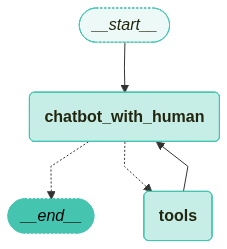

In [53]:
# 도구 리스트 업데이트
tools_with_human = [human_assistance]

# 새로운 그래프 구성
graph_builder_hitl = StateGraph(State)

# LLM에 도구 바인딩
llm_with_human_tools = llm.bind_tools(tools_with_human)


def chatbot_with_human(state: State):
    """Human Interuption 요청할 수 있는 챗봇"""
    message = llm_with_human_tools.invoke(state["messages"])

    # interrupt 중 병렬 도구 호출 방지
    # (재개 시 도구 호출이 반복되는 것을 방지)
    if hasattr(message, "tool_calls"):
        assert (
            len(message.tool_calls) <= 1
        ), "병렬 도구 호출은 interrupt와 함께 사용할 수 없습니다"

    return {"messages": [message]}


# 노드 추가
graph_builder_hitl.add_node("chatbot_with_human", chatbot_with_human)

# ToolNode 추가
tool_node_hitl = ToolNode(tools=tools_with_human)
graph_builder_hitl.add_node("tools", tool_node_hitl)

# 엣지 추가
graph_builder_hitl.add_conditional_edges("chatbot_with_human", tools_condition)
graph_builder_hitl.add_edge("tools", "chatbot_with_human")
graph_builder_hitl.add_edge(START, "chatbot_with_human")

# 메모리와 함께 컴파일
memory_hitl = InMemorySaver()
graph_hitl = graph_builder_hitl.compile(checkpointer=memory_hitl)

# 그래프 시각화
visualize_graph(graph_hitl)

### 🎬 HITL 테스트

사람에게 조언을 요청하는 질문으로 interrupt 와 재개 흐름을 검증합니다.

- **질문**: "LangGraph 잘하고 싶은데, 사람에게 조언을 듣고 싶어요."  
- **기대 흐름**: chatbot → tools(`human_assistance`) → interrupt → 재개(Command) → 답변 완성  
- **확인 포인트**: 중단 지점, 체크포인트 ID, 재개 후 일관성

In [54]:
from langchain_teddynote.messages import random_uuid

# 인간 지원을 요청하는 메시지
user_input = "LangGraph 가 뭐야? 사람한테 듣고 싶어."
config_hitl = {"configurable": {"thread_id": random_uuid()}}

print(f"User: {user_input}\n")

stream_graph(
    graph_hitl,
    inputs={"messages": [HumanMessage(content=user_input)]},
    config=config_hitl,
)

User: LangGraph 가 뭐야? 사람한테 듣고 싶어.


🔄 Node: chatbot_with_human 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 


In [55]:
# 상태 확인 - 어느 노드에서 중단되었는지 확인
snapshot = graph_hitl.get_state(config_hitl)
print(f"\n📊 현재 상태:")
print(f"  다음 실행할 노드: {snapshot.next}")
print(f"  체크포인트 ID: {snapshot.config['configurable']['checkpoint_id']}")


📊 현재 상태:
  다음 실행할 노드: ('tools',)
  체크포인트 ID: 1f0aa592-de9c-63ca-8001-1faa0bbd65e5


In [56]:
# 인간의 응답으로 실행 재개
human_response = """## 전문가의 조언:
- YouTube 테디노트: https://www.youtube.com/c/teddynote
- 고급 개발자 강의 [패스트캠퍼스 RAG 비법노트](https://fastcampus.co.kr/data_online_teddy)
"""

# Command 객체로 재개
human_command = Command(resume={"data": human_response}) #resume 안주면 처음부터 시작함

print(f"\n💡 사람의 응답: {human_response}\n")

# 재개
stream_graph(graph_hitl, inputs=human_command, config=config_hitl)


💡 사람의 응답: ## 전문가의 조언:
- YouTube 테디노트: https://www.youtube.com/c/teddynote
- 고급 개발자 강의 [패스트캠퍼스 RAG 비법노트](https://fastcampus.co.kr/data_online_teddy)



🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
## 전문가의 조언:
- YouTube 테디노트: https://www.youtube.com/c/teddynote
- 고급 개발자 강의 [패스트캠퍼스 RAG 비법노트](https://fastcampus.co.kr/data_online_teddy)

🔄 Node: chatbot_with_human 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
LangGraph는 최근 인공지능 및 자연어처리(NLP) 분야에서 주목받는 프레임워크입니다. LangGraph는 여러 개의 LLM(대형 언어 모델)이나 다양한 AI 컴포넌트들을 그래프 형태로 연결해서, 복잡한 대화 흐름이나 데이터 처리 파이프라인을 쉽게 설계하고 실행할 수 있게 도와줍니다.

즉, 기존에는 챗봇이나 RAG(검색 기반 생성) 시스템을 만들 때 여러 단계를 일일이 코드로 짜야 했다면, LangGraph를 사용하면 각 단계를 노드로 만들고, 이 노드들을 그래프처럼 연결해서 복잡한 작업도 시각적으로 설계할 수 있습니다.

더 자세한 설명이나 실습은 아래의 전문가 자료를 참고해보세요:
- YouTube 테디노트: https://www.youtube.com/c/teddynote
- 패스트캠퍼스 RAG 비법노트 강의: https://fastcampus.co.kr/data_online_teddy

궁금한 점이 더 있으면 언제든 질문해 주세요!

---

# Part 5: 상태 커스터마이징

## 🎯 목적
메시지 외 업무 데이터까지 다루는 **커스텀 상태**와 **도구 기반 상태 업데이트**를 도입합니다.

### 핵심 개념
- **Custom State Fields**: 메시지 외 검토용/결과용 필드 추가
- **State Updates from Tools**: 도구 결과로 상태 자동 갱신
- **Manual State Updates**: 필요 시 수동으로 상태 수정

### 아키텍처 패턴
```
사용자 입력 → 정보 수집(도구) → 임시 저장(State)
             ↓
           검토/수정 → 최종 결과(State)
```

### 기대 효과
- **복합 상태 관리**, **프로세스 자동화**, **품질 보증**, **유연한 수정**

In [57]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId


# 확장된 State 정의
class CustomState(TypedDict):
    """커스텀 필드가 추가된 상태"""

    messages: Annotated[list, add_messages]
    human_feedback: str  # 사람의 피드백

### 상태 업데이트 도구

도구 실행 결과를 `Command(update=...)` 로 상태에 반영하는 패턴을 사용합니다.

In [ ]:
@tool
def human_review(
    human_feedback, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request human review for information."""
    # 인간에게 검토 요청
    human_response = interrupt(
        {"question": "이 정보가 맞나요?", "human_feedback": human_feedback}
    )

    feedback = human_response.get("human_feedback", "")

    if feedback.strip() == "":
        # 사용자가 AI 의 답변에 동의하는 경우
        return Command(
            update={ # update가 추가된 쿼리 , 원래 tool안에서는 update가 안됐음.
                "messages": [ToolMessage(human_response, tool_call_id=tool_call_id)]
            }
        )
    else:
        # 사용자가 AI 의 답변에 동의하지 않는 경우
        corrected_information = f"# 사용자에 의해 수정된 피드백: {feedback}"
        return Command(
            update={
                "messages": [
                    ToolMessage(corrected_information, tool_call_id=tool_call_id)
                ]
            }
        )

### 커스텀 상태 그래프

커스텀 필드를 포함한 `CustomState` 로 그래프를 구성하고, 도구를 통한 상태 업데이트 루프를 적용합니다.

In [60]:
# 도구 리스트
tools_custom = [human_review]

# 새로운 그래프 구성
custom_graph_builder = StateGraph(CustomState)  # CustomState 사용

# LLM에 도구 바인딩
llm_with_custom_tools = llm.bind_tools(tools_custom)


def chatbot_custom(state: CustomState):
    """커스텀 상태를 사용하는 챗봇"""
    message = llm_with_custom_tools.invoke(state["messages"])

    if hasattr(message, "tool_calls"):
        assert len(message.tool_calls) <= 1

    return {"messages": [message]}


# 노드와 엣지 추가
custom_graph_builder.add_node("chatbot", chatbot_custom)
tool_node_custom = ToolNode(tools=tools_custom)
custom_graph_builder.add_node("tools", tool_node_custom)

custom_graph_builder.add_conditional_edges("chatbot", tools_condition)
custom_graph_builder.add_edge("tools", "chatbot")
custom_graph_builder.add_edge(START, "chatbot")

# 컴파일
memory_custom = InMemorySaver()
custom_graph = custom_graph_builder.compile(checkpointer=memory_custom)

그래프 시각화로 노드와 조건부 분기, 루프 구성을 확인합니다.

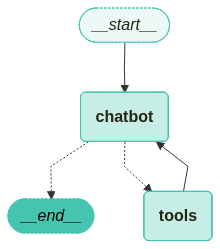

In [ ]:
# 그래프 시각화
visualize_graph(custom_graph)

# 이번에[는 tools안에 toolmeassage를 직접 수정하는 기능넣ㄹ어준거

### 커스텀 상태 테스트

`human_review` 도구 호출에서 interrupt 로 중단된 뒤, 재개 시 상태가 올바르게 갱신되는지 확인합니다.

In [62]:
# LangGraph의 출시일을 조사하고 검토 요청
user_input = (
    "2024년 노벨 문학상 수상자가 누구인지 조사해주세요. "
    "답을 찾으면 `human_review` 도구를 사용해서 검토를 요청하세요."
)

custom_config = RunnableConfig(configurable={"thread_id": random_uuid()})

print(f"User: {user_input}\n")

# 실행 (interrupt에서 중단될 것임)
stream_graph(
    custom_graph,
    inputs={"messages": [HumanMessage(content=user_input)]},
    config=custom_config,
)

User: 2024년 노벨 문학상 수상자가 누구인지 조사해주세요. 답을 찾으면 `human_review` 도구를 사용해서 검토를 요청하세요.


🔄 Node: chatbot 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 


In [63]:
from langchain_teddynote.messages import display_message_tree

# 최신 메시지 가져오기
last_message = custom_graph.get_state(custom_config).values["messages"][-1]

# 최신 메시지 tree 구조로 표시
display_message_tree(last_message)

    content: ""
    additional_kwargs:
        tool_calls:
            index [0]
                index: 0
                id: "call_3N05o2rEbao932QlNII71hrQ"
                function: {"arguments": "{"human_feedback":"2024년 노벨 문학상 수상자는 현재 공식적으로 발표되지 않았거나, 최신 정보가 필요합니다. 사용자의 요청에 따라 최신 정보를 확인하고 검토를 요청합니다."}", "name": "human_review"}
                type: "function"
    response_metadata: {"finish_reason": "tool_calls", "model_name": "gpt-4.1-2025-04-14", "system_fingerprint": "fp_e24a1fec47", "service_tier": "default"}
    type: "ai"
    name: None
    id: "run--0bd43a08-4226-4476-b767-e20284bc4460"
    example: False
    tool_calls:
        index [0]
            name: "human_review"
            args: {"human_feedback": "2024년 노벨 문학상 수상자는 현재 공식적으로 발표되지 않았거나, 최신 정보가 필요합니다. 사용자의 요청에 따라 최신 정보를 확인하고 검토를 요청합니다."}
            id: "call_3N05o2rEbao932QlNII71hrQ"
            type: "tool_call"
    invalid_tool_calls:
    usage_metadata:
        input_tokens: 79
        output_tokens: 55
        t

In [64]:
# AI 가 작성한 내용
print(last_message.tool_calls[0]["args"]["human_feedback"])

2024년 노벨 문학상 수상자는 현재 공식적으로 발표되지 않았거나, 최신 정보가 필요합니다. 사용자의 요청에 따라 최신 정보를 확인하고 검토를 요청합니다.


In [65]:
# 인간의 검토 응답으로 재개
human_command = Command(
    resume={"human_feedback": "2024년 노벨 문학상 수상자는 대한민국의 한강 작가입니다."}
)

stream_graph(custom_graph, inputs=human_command, config=custom_config)


🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
# 사용자에 의해 수정된 피드백: 2024년 노벨 문학상 수상자는 대한민국의 한강 작가입니다.
🔄 Node: chatbot 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
2024년 노벨 문학상 수상자는 대한민국의 한강 작가입니다. 이 정보는 사용자에 의해 검토 및 수정되었습니다.

---

# Part 6: 상태 이력 관리

## 🎯 목적
체크포인트 기반으로 상태를 저장/복원해 **롤백/재실행** 시나리오를 실습합니다.

### 핵심 개념
- **State History**: 상태 변경 이력 관리(추적/복원)  
- **Checkpoint ID**: 특정 시점 식별자  
- **Rollback**: 지정 시점으로 복원  
- **Resume**: 복원 상태에서 재실행

### 기대 효과
- **안전한 실험**, **디버깅 효율**, **A/B 테스트**, **안정성 향상**

### 체크포인트 기반 그래프 구성

상태 이력 확인과 롤백/재실행을 위한 최소 구성으로 시작합니다.

- **도구**: 검색(Tavily)  
- **체크포인터**: InMemorySaver  
- **이력 조회**: `get_state_history`

In [66]:
# 상태 관리 테스트를 위한 체크포인트 기반 그래프
graph_builder = StateGraph(State)

# 도구와 LLM 설정
tools = [TavilySearch(max_results=2)]
llm_with_tools_tt = llm.bind_tools(tools)


def chatbot_tt(state: State):
    """상태 관리 테스트용 챗봇"""
    return {"messages": [llm_with_tools_tt.invoke(state["messages"])]}


# 그래프 구성
graph_builder.add_node("chatbot", chatbot_tt)
tool_node_tt = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node_tt)

graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# 메모리와 함께 컴파일
memory_tt = InMemorySaver()
time_travel_graph = graph_builder.compile(checkpointer=memory_tt)

### 구조 시각화

체크포인트 기반 그래프 구조를 시각화하여 분기와 루프를 확인합니다.

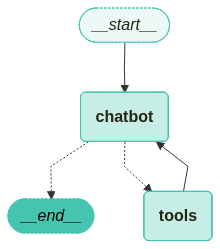

In [67]:
# 시각화
visualize_graph(time_travel_graph)

### 체크포인트 시퀀스 생성

여러 번 대화를 실행해 충분한 상태 이력을 만듭니다.

- 체크포인트 1: 첫 대화 종료  
- 체크포인트 2: 두 번째 대화 종료  
- 체크포인트 3: 이후 확장(선택)

In [68]:
time_travel_config = RunnableConfig(configurable={"thread_id": "time-travel-1"})

# 첫 번째 대화
stream_graph(
    time_travel_graph,
    inputs={"messages": [HumanMessage(content="테디노트에 대해서 조사 좀 해주세요.")]},
    config=time_travel_config,
)


🔄 Node: chatbot 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"query": "테디노트", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.youtube.com/channel/UCt2wAAXgm87ACiQnDHQEW6Q", "title": "테디노트 TeddyNote - YouTube", "content": "데이터 분석, 머신러닝, 딥러닝, LLM 에 대한 내용을 다룹니다. 연구보다는 개발에 관심이 많습니다 ‍♂️ ...more 데이터 분석, 머신러닝, 딥러닝, LLM 에 대한 내용을", "score": 0.98527, "raw_content": null}, {"url": "https://teddylee777.github.io/", "title": "테디노트", "content": "## LangGraph Retrieval Agent를 활용한 동적 문서 검색 및 처리 LangGraph Retrieval Agent는 언어 처리, AI 모델 통합, 데이터베이스 관리, 그래프 기반 데이터 처리 등 다양한 기능을 제공하여 언어 기반 AI 애플리케이션 개발에 필수적인 도구입니다. ## [[Assistants API] Code Interpreter, Retrieval, Functions 활용법](/openai/openai-assistant-tutorial/) ## [[LangChain] 에이전트(Agent)와 도구(tools)를 활용한 지능형 검색 시스템 구축 가이드](/langchain/langchain-agent/) 이 글에서는 LangChain 의 Agent 프레임워크를 활용하여 복잡한 검색과 데이터 처리 작업을 수행하는 방법을 소개합니다. ## LangChain 

In [69]:
# 두 번째 대화
stream_graph(
    time_travel_graph,
    inputs={
        "messages": [
            HumanMessage(content="테디노트 온라인 강의 주소를 조사해 해주세요.")
        ]
    },
    config=time_travel_config,
)


🔄 Node: chatbot 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"query": "테디노트 온라인 강의 주소", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://fastcampus.co.kr/data_online_teddy", "title": "테디노트의 RAG 비법노트 : GPT·로컬 모델부터 LangGraph·Agent까지", "content": "패스트캠퍼스 온라인 강의 시청을 위해서는 ID별 최대 3개의 기기를 등록할 수 있으며, 기기 등록은 온라인 강의장 접속 시 자동 등록됩니다. 최대 갯수를 초과하였을 경우", "score": 0.98597, "raw_content": null}, {"url": "https://teddylee777.github.io/lectures/", "title": "강의 - 테디노트", "content": "# 강의 * **인프런** 강의 상세내용 보러가기 * **런어데이** 강의 상세내용 보러가기 * **인프런** 강의 상세내용 보러가기 * **런어데이** 강의 상세내용 보러가기 * **유데미** 강의 상세내용 보러가기 * **인프런** 강의 상세내용 보러가기 * **런어데이** 강의 상세내용 보러가기 차별화된 깃헙 블로그(GitHub blog) 만들어 보고 싶으신 분들께 추천 드립니다🤩 * **인프런** 강의 상세내용 보러가기 * 스트림릿(streamlit)을 활용하여 파이썬 웹앱 대시보드를 구현해보고 싶으신 분들께 추천 드립니다🤩 * **인프런** 강의 상세내용 보러가기 그 밖에도 다양한 주제로 강의 영상을 유튜브(YouTube) 채널에 업로드 하고 있어요 `주제별로 강의 영상`을 시리즈로 모아 놓았어요😊 📌 지금 당장 **유튜브**

### 상태 이력 탐색 및 시점 선택

`get_state_history` 로 이력을 조회하고, 롤백/재실행할 체크포인트를 선택합니다.

- **조회 항목**: 다음 노드, 체크포인트 ID, 메시지 수  
- **선택 기준**: 수정하고 싶은 단계 직후의 안정 시점

In [70]:
# 전체 상태 히스토리 확인
print("📜 상태 히스토리 (최신순):")
print("=" * 80)

# to_replay 변수 초기화
to_replay = None

for i, state in enumerate(time_travel_graph.get_state_history(time_travel_config)):
    print(f"\n[체크포인트 {i}]")
    print(f"  다음 노드: {state.next}")
    print(f"  체크포인트 ID: {state.config['configurable']['checkpoint_id']}")

    if len(state.values["messages"]) == 6 and to_replay is None:
        print("  ⭐ 이 상태로 되돌아갈 예정")
        display_message_tree(state.values["messages"][-1])
        to_replay = state


print("\n" + "=" * 80)

📜 상태 히스토리 (최신순):

[체크포인트 0]
  다음 노드: ()
  체크포인트 ID: 1f0aa5ad-f3fe-6536-8008-c90b967d8e64

[체크포인트 1]
  다음 노드: ('chatbot',)
  체크포인트 ID: 1f0aa5ad-ce3f-643a-8007-6ffa098b910f

[체크포인트 2]
  다음 노드: ('tools',)
  체크포인트 ID: 1f0aa5ad-c60a-61e8-8006-bb71fb2663d6
  ⭐ 이 상태로 되돌아갈 예정
    content: ""
    additional_kwargs:
        tool_calls:
            index [0]
                index: 0
                id: "call_KMItdAXLFWERL8EdaSY7W6y0"
                function: {"arguments": "{"query":"테디노트 온라인 강의 주소"}", "name": "tavily_search"}
                type: "function"
    response_metadata: {"finish_reason": "tool_calls", "model_name": "gpt-4.1-2025-04-14", "system_fingerprint": "fp_422e2d36a8", "service_tier": "default"}
    type: "ai"
    name: None
    id: "run--119c0675-0164-4121-bf14-8904fd79b92a"
    example: False
    tool_calls:
        index [0]
            name: "tavily_search"
            args: {"query": "테디노트 온라인 강의 주소"}
            id: "call_KMItdAXLFWERL8EdaSY7W6y0"
            type: "tool_c

### 특정 체크포인트로 롤백

선택한 체크포인트로 상태를 복원하여 이후 단계를 재실행할 준비를 합니다.

- **대상**: 두 번째 검색 완료 시점  
- **목적**: 검색 전략 변경 후 결과 비교

In [71]:
display_message_tree(to_replay.values["messages"][-1])

    content: ""
    additional_kwargs:
        tool_calls:
            index [0]
                index: 0
                id: "call_KMItdAXLFWERL8EdaSY7W6y0"
                function: {"arguments": "{"query":"테디노트 온라인 강의 주소"}", "name": "tavily_search"}
                type: "function"
    response_metadata: {"finish_reason": "tool_calls", "model_name": "gpt-4.1-2025-04-14", "system_fingerprint": "fp_422e2d36a8", "service_tier": "default"}
    type: "ai"
    name: None
    id: "run--119c0675-0164-4121-bf14-8904fd79b92a"
    example: False
    tool_calls:
        index [0]
            name: "tavily_search"
            args: {"query": "테디노트 온라인 강의 주소"}
            id: "call_KMItdAXLFWERL8EdaSY7W6y0"
            type: "tool_call"
    invalid_tool_calls:
    usage_metadata:
        input_tokens: 2089
        output_tokens: 23
        total_tokens: 2112
        input_token_details: {"audio": 0, "cache_read": 2048}
        output_token_details: {"audio": 0, "reasoning": 0}


### 상태 수정 및 최적화

복원된 상태에서 도구 호출 파라미터를 수정해 다른 결과를 유도합니다.

- **예시 변경**: `query` 를 도메인 한정으로 수정(`site:...`)  
- **목표**: 정확도 향상 및 결과 품질 비교(A/B)

런타임 파라미터 수정은 재실행 비용을 줄이면서 최적화를 빠르게 검증할 수 있습니다.

In [72]:
from langchain_teddynote.tools import update_tool_call

# 사용 예시:
updated_message = update_tool_call(
    to_replay.values["messages"][-1],
    tool_name="tavily_search",
    tool_args={"query": "[LG전자 메뉴얼] 궤도 강의 youtube", "search_depth": "basic"},
)

In [73]:
updated_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_KMItdAXLFWERL8EdaSY7W6y0', 'function': {'arguments': '{"query": "[LG전자 메뉴얼] 궤도 강의 youtube", "search_depth": "basic"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_422e2d36a8', 'service_tier': 'default'}, id='run--119c0675-0164-4121-bf14-8904fd79b92a', tool_calls=[{'name': 'tavily_search', 'args': {'query': '[LG전자 메뉴얼] 궤도 강의 youtube', 'search_depth': 'basic'}, 'id': 'call_KMItdAXLFWERL8EdaSY7W6y0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2089, 'output_tokens': 23, 'total_tokens': 2112, 'input_token_details': {'audio': 0, 'cache_read': 2048}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [74]:
# 변경하기 전의 message
display_message_tree(to_replay.values["messages"][-1])

    content: ""
    additional_kwargs:
        tool_calls:
            index [0]
                index: 0
                id: "call_KMItdAXLFWERL8EdaSY7W6y0"
                function: {"arguments": "{"query": "[LG전자 메뉴얼] 궤도 강의 youtube", "search_depth": "basic"}", "name": "tavily_search"}
                type: "function"
    response_metadata: {"finish_reason": "tool_calls", "model_name": "gpt-4.1-2025-04-14", "system_fingerprint": "fp_422e2d36a8", "service_tier": "default"}
    type: "ai"
    name: None
    id: "run--119c0675-0164-4121-bf14-8904fd79b92a"
    example: False
    tool_calls:
        index [0]
            name: "tavily_search"
            args: {"query": "테디노트 온라인 강의 주소"}
            id: "call_KMItdAXLFWERL8EdaSY7W6y0"
            type: "tool_call"
    invalid_tool_calls:
    usage_metadata:
        input_tokens: 2089
        output_tokens: 23
        total_tokens: 2112
        input_token_details: {"audio": 0, "cache_read": 2048}
        output_token_details: {"audio": 0,

In [75]:
# 변경한 이후의 메시지 트리
display_message_tree(updated_message)

    content: ""
    additional_kwargs:
        tool_calls:
            index [0]
                index: 0
                id: "call_KMItdAXLFWERL8EdaSY7W6y0"
                function: {"arguments": "{"query": "[LG전자 메뉴얼] 궤도 강의 youtube", "search_depth": "basic"}", "name": "tavily_search"}
                type: "function"
    response_metadata: {"finish_reason": "tool_calls", "model_name": "gpt-4.1-2025-04-14", "system_fingerprint": "fp_422e2d36a8", "service_tier": "default"}
    type: "ai"
    name: None
    id: "run--119c0675-0164-4121-bf14-8904fd79b92a"
    example: False
    tool_calls:
        index [0]
            name: "tavily_search"
            args: {"query": "[LG전자 메뉴얼] 궤도 강의 youtube", "search_depth": "basic"}
            id: "call_KMItdAXLFWERL8EdaSY7W6y0"
            type: "tool_call"
    invalid_tool_calls:
    usage_metadata:
        input_tokens: 2089
        output_tokens: 23
        total_tokens: 2112
        input_token_details: {"audio": 0, "cache_read": 2048}
       

In [76]:
# 변경된 메시지를 update_state 로 업데이트
updated_state = time_travel_graph.update_state(
    values={"messages": [updated_message]}, config=to_replay.config
)

### 수정 상태 재실행

업데이트된 상태로 재실행하여 결과를 비교합니다.

- **실행 방식**: 입력 없이 업데이트된 상태로 재개  
- **비교 항목**: 원래 결과 vs 수정 후 결과  
- **기대 효과**: 정확도 향상, 비용 절감, 빠른 실험 사이클

In [77]:
# 업데이트된 메시지를 스트리밍 합니다.
stream_graph(time_travel_graph, inputs=None, config=updated_state)


🔄 Node: chatbot 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
테디노트의 온라인 강의는 여러 플랫폼에서 제공되고 있습니다. 주요 강의 주소는 다음과 같습니다:

1. 패스트캠퍼스: 테디노트의 RAG 비법노트 (GPT·로컬 모델부터 LangGraph·Agent까지)
   - 강의 주소: https://fastcampus.co.kr/data_online_teddy

2. 테디노트 공식 블로그의 강의 모음 페이지
   - 다양한 인프런, 런어데이, 유데미 등 강의 링크가 정리되어 있습니다.
   - 강의 주소: https://teddylee777.github.io/lectures/

이 외에도 테디노트 유튜브 채널에서 무료 강의 영상도 시청할 수 있습니다.

필요한 특정 강의 플랫폼(인프런, 유데미 등)이 있다면 추가로 안내해드릴 수 있습니다!